### SSH based plots and sections 


In [1]:
import numpy as np
import xarray as xr

import glidertools as gt
from cmocean import cm as cmo

import gsw

import matplotlib.pyplot as plt

In [51]:
plt.style.use('seaborn-colorblind')
plt.rcParams['font.size'] = 16

In [3]:
def datetime2ytd(time):
    """" Return time in YTD format from datetime format."""
    return  (time - np.datetime64('2019-01-01'))/np.timedelta64(1, 'D')
    

In [4]:
ds_660_z = xr.open_dataset('data/ctd_O2_660_vert_4m_binned_22_sept_2021.nc')
# Calculate a time axis as YTD
ds_660_z['days'] = datetime2ytd(ds_660_z.time)

In [5]:
ds_SSH = xr.open_dataset('/Users/dhruvbalwada/OneDrive/sogos_data/data/for_dashboard/SSH_sogos.nc')
ds_SSH = ds_SSH.assign_coords(days = datetime2ytd(ds_SSH.time))

In [59]:
ds_SSH

<xarray.Dataset>
Dimensions:    (time: 88, latitude: 25, longitude: 49)
Coordinates:
  * time       (time) datetime64[ns] 2019-04-29 2019-04-30 ... 2019-07-25
  * latitude   (latitude) float32 -54.88 -54.62 -54.38 ... -49.38 -49.12 -48.88
  * longitude  (longitude) float32 28.12 28.38 28.62 28.88 ... 39.62 39.88 40.12
    days       (time) float64 118.0 119.0 120.0 121.0 ... 203.0 204.0 205.0
Data variables:
    adt        (time, latitude, longitude) float64 ...
    ugos       (time, latitude, longitude) float64 ...
    vgos       (time, latitude, longitude) float64 ...
    vgosa      (time, latitude, longitude) float64 ...
    err        (time, latitude, longitude) float64 ...
    sla        (time, latitude, longitude) float64 ...
    ugosa      (time, latitude, longitude) float64 ...
Attributes: (12/46)
    _NCProperties:                   version=1|netcdflibversion=4.4.1.1|hdf5l...
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    time_coverage_duration:          P1D
    time_coverage_end:               2019-09-04T00:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2019-09-04T00:00:00Z
    title:                           NRT merged all satellites Global Ocean G...
    History:                         Translated to CF-1.0 Conventions by Netc...

### Convert from dives to time

In [24]:
# Interpolate to a uniform time grid
from scipy import interpolate

def interp_time(ds, var): 
    time_grid = np.arange(120, 205, 1/24)

   
    for i in range(len(ds.ctd_pressure)):
        ds_temp =ds.isel(ctd_pressure=i)
        
        f = interpolate.interp1d(ds_temp.days, ds_temp[var])
        var_int = f(time_grid)
        
        da_var_int_temp = xr.DataArray(var_int,
                                 dims=["days"],
                                 coords={"days": time_grid, "ctd_pressure": ds_temp.ctd_pressure}
                                 ).rename(var)
        
        if i==0:
            da_var_int = da_var_int_temp
        else:
            da_var_int = xr.concat([da_var_int, da_var_int_temp], dim='ctd_pressure')
        
    return da_var_int

In [42]:
ds_660_time = xr.merge([interp_time(ds_660_z,'sigma0'),
                        interp_time(ds_660_z,'CT'),
                        interp_time(ds_660_z,'SA'),
                        interp_time(ds_660_z,'dives'),
                        interp_time(ds_660_z,'longitude'),
                        interp_time(ds_660_z,'latitude')])

In [43]:
ds_660_time

<xarray.Dataset>
Dimensions:       (days: 2040, ctd_pressure: 250)
Coordinates:
  * days          (days) float64 120.0 120.0 120.1 120.1 ... 204.9 204.9 205.0
  * ctd_pressure  (ctd_pressure) float64 2.0 6.0 10.0 14.0 ... 990.0 994.0 998.0
Data variables:
    sigma0        (ctd_pressure, days) float64 27.04 27.04 27.04 ... nan nan nan
    CT            (ctd_pressure, days) float64 3.585 3.585 3.608 ... nan nan nan
    SA            (ctd_pressure, days) float64 34.17 34.17 34.17 ... nan nan nan
    dives         (ctd_pressure, days) float64 8.253 9.112 9.496 ... nan nan nan
    longitude     (ctd_pressure, days) float64 30.35 30.39 30.42 ... nan nan nan
    latitude      (ctd_pressure, days) float64 -51.33 -51.32 -51.31 ... nan nan

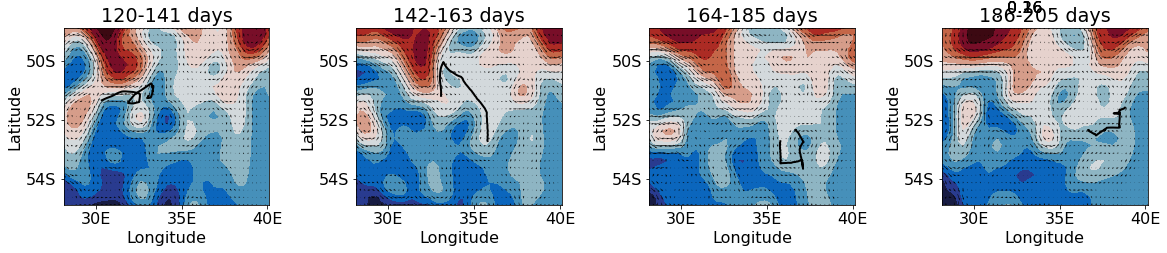

In [81]:
plt.figure(figsize=(2.2*7.5, 3.8))

plt.subplot(141)
ds_SSH.adt.isel(time=slice(0, 21)).mean('time').plot.contourf(levels=np.linspace(-1.2,0, 13), cmap=cmo.balance,
                                                             add_colorbar=False)
ds_SSH.isel(time=slice(0, 21)).mean('time').plot.quiver(x='longitude', y='latitude', u='ugos', v='vgos')

plt.plot(ds_660_time.sel(days=slice(120,142)).sel(ctd_pressure=200, method='nearest').longitude,
         ds_660_time.sel(days=slice(120,142)).sel(ctd_pressure=200, method='nearest').latitude,
        linewidth=2, color='k')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('120-141 days')
plt.xticks([30, 35, 40], labels=['30E', '35E', '40E'])
plt.yticks([-54, -52, -50], labels=['54S', '52S', '50S'])

plt.subplot(142)
ds_SSH.adt.isel(time=slice(21, 43)).mean('time').plot.contourf(levels=np.linspace(-1.2,0, 13), cmap=cmo.balance,
                                                             add_colorbar=False)
ds_SSH.isel(time=slice(21, 43)).mean('time').plot.quiver(x='longitude', y='latitude', u='ugos', v='vgos')

plt.plot(ds_660_time.sel(days=slice(142,164)).sel(ctd_pressure=200, method='nearest').longitude,
         ds_660_time.sel(days=slice(142,164)).sel(ctd_pressure=200, method='nearest').latitude,
        linewidth=2, color='k')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('142-163 days')
plt.xticks([30, 35, 40], labels=['30E', '35E', '40E'])
plt.yticks([-54, -52, -50], labels=['54S', '52S', '50S'])

plt.subplot(143)
ds_SSH.adt.isel(time=slice(43, 65)).mean('time').plot.contourf(levels=np.linspace(-1.2,0, 13), cmap=cmo.balance,
                                                             add_colorbar=False)
ds_SSH.isel(time=slice(43, 65)).mean('time').plot.quiver(x='longitude', y='latitude', u='ugos', v='vgos')

plt.plot(ds_660_time.sel(days=slice(164,186)).sel(ctd_pressure=200, method='nearest').longitude,
         ds_660_time.sel(days=slice(164,186)).sel(ctd_pressure=200, method='nearest').latitude,
        linewidth=2, color='k')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('164-185 days')
plt.xticks([30, 35, 40], labels=['30E', '35E', '40E'])
plt.yticks([-54, -52, -50], labels=['54S', '52S', '50S'])

plt.subplot(144)
ds_SSH.adt.isel(time=slice(65, 88)).mean('time').plot.contourf(levels=np.linspace(-1.2,0, 13), cmap=cmo.balance,
                                                             add_colorbar=False)#, cbar_kwargs={'label': 'SSH [m]'})
ds_SSH.isel(time=slice(65, 88)).mean('time').plot.quiver(x='longitude', y='latitude', u='ugos', v='vgos')

plt.plot(ds_660_time.sel(days=slice(186,206)).sel(ctd_pressure=200, method='nearest').longitude,
         ds_660_time.sel(days=slice(186,206)).sel(ctd_pressure=200, method='nearest').latitude,
        linewidth=2, color='k')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('186-205 days')
plt.xticks([30, 35, 40], labels=['30E', '35E', '40E'])
plt.yticks([-54, -52, -50], labels=['54S', '52S', '50S'])

plt.tight_layout()

plt.savefig('figures/figure_SSH_panel1.pdf')

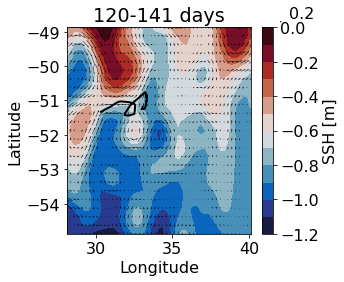

In [78]:
plt.figure(figsize=(2.2*7.5/4, 3.8))

plt.subplot(111)
ds_SSH.adt.isel(time=slice(0, 21)).mean('time').plot.contourf(levels=np.linspace(-1.2,0, 13), cmap=cmo.balance,
                                                             add_colorbar=True, cbar_kwargs={'label': 'SSH [m]'})
ds_SSH.isel(time=slice(0, 21)).mean('time').plot.quiver(x='longitude', y='latitude', u='ugos', v='vgos')

plt.plot(ds_660_time.sel(days=slice(120,142)).sel(ctd_pressure=200, method='nearest').longitude,
         ds_660_time.sel(days=slice(120,142)).sel(ctd_pressure=200, method='nearest').latitude,
        linewidth=2, color='k')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('120-141 days')


plt.savefig('figures/figure_SSH_panel1cbar.pdf')

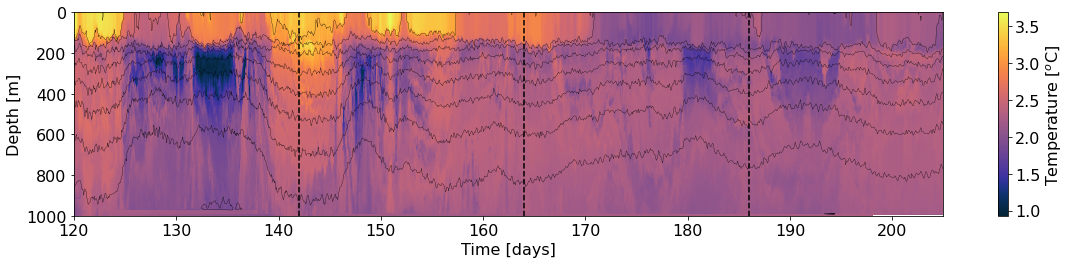

In [76]:
plt.figure(figsize=(2.2*7.5,2.2*1.8))
ds_660_time.CT.plot(cmap=cmo.thermal, rasterized=True, cbar_kwargs={'label': 'Temperature [$^o$C]'})
ds_660_time.sigma0.plot.contour(levels=np.linspace(27.0, 27.9,10), colors='k', linewidths=0.3)
plt.gca().invert_yaxis()

plt.vlines([142, 164, 186], 0, 1000, linestyles='--', colors='k')
#plt.xticks([0, 4e5, 8e5, 12e5, 16e5], labels=[0, 400, 800, 1200, 1600])
plt.xlabel('Time [days]')
plt.ylabel('Depth [m]')

plt.tight_layout()

plt.savefig('figures/figure_SSH_panel2.pdf')

### Scraps

In [ ]:
plt.figure(figsize=(2.2*7.5, 6))

plt.subplot(121)
ds_SSH.adt.isel(time=slice(0, 30)).mean('time').plot.contourf(levels=np.linspace(-1.2,0, 13), cmap=cmo.balance)
ds_SSH.isel(time=slice(0, 30)).mean('time').plot.quiver(x='longitude', y='latitude', u='ugos', v='vgos')

plt.plot(ds_660_z.where(ds_660_z.days<=150, drop=True).sel(ctd_pressure=200, method='nearest').longitude,
         ds_660_z.where(ds_660_z.days<=150, drop=True).sel(ctd_pressure=200, method='nearest').latitude)


plt.subplot(122)
#ds_660_z.where(ds_660_z.days<=150, drop=True).CT.plot(cmap=cmo.thermal, vmin=1, vmax=3.2, rasterized=True)
ds_660_time.CT.sel(days = slice(119, 150)).plot(cmap=cmo.thermal, vmin=1, vmax=3.2, rasterized=True)
plt.gca().invert_yaxis()

plt.tight_layout()

#plt.savefig('./figures/ssh_sec1.pdf')

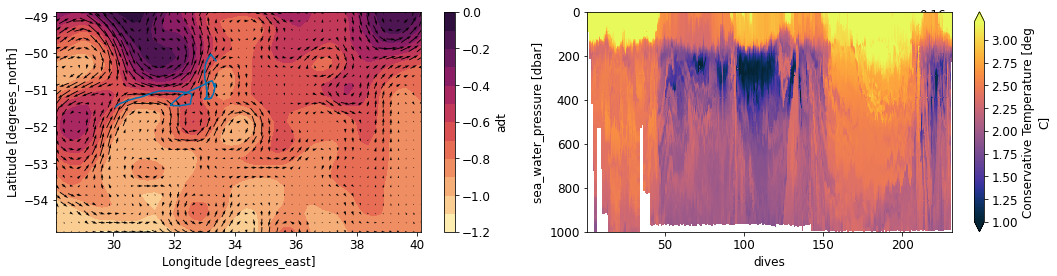

In [20]:
plt.figure(figsize=(15, 4))

plt.subplot(121)
ds_SSH.adt.isel(time=slice(0, 30)).mean('time').plot.contourf(levels=np.linspace(-1.2,0, 13), cmap=cmo.matter)
ds_SSH.isel(time=slice(0, 30)).mean('time').plot.quiver(x='longitude', y='latitude', u='ugos', v='vgos')
plt.plot(ds_660_time.where(ds_660_z.days<=150, drop=True).sel(ctd_pressure=200, method='nearest').longitude,
         ds_660_z.where(ds_660_z.days<=150, drop=True).sel(ctd_pressure=200, method='nearest').latitude)


plt.subplot(122)
ds_660_z.where(ds_660_z.days<=150, drop=True).CT.plot(cmap=cmo.thermal, vmin=1, vmax=3.2, rasterized=True)
plt.gca().invert_yaxis()

plt.tight_layout()

#plt.savefig('./figures/ssh_sec1.pdf')

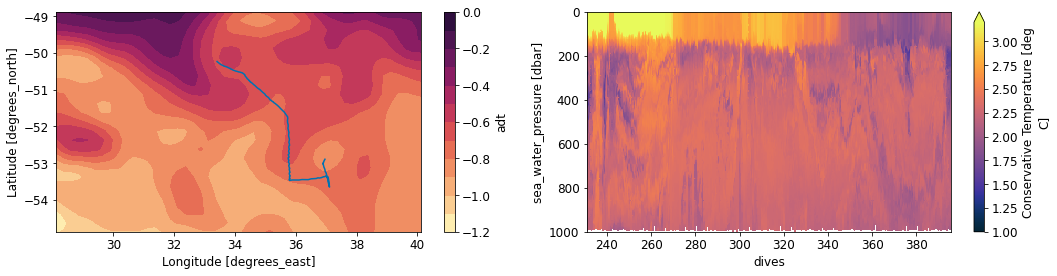

In [77]:
plt.figure(figsize=(15, 4))

ds_660_sel = ds_660_z.where( (ds_660_z.days>=150) & (ds_660_z.days<=180), drop=True)

plt.subplot(121)
ds_SSH.adt.isel(time=slice(30, 60)).mean('time').plot.contourf(levels=np.linspace(-1.2,0, 13), cmap=cmo.matter)
plt.plot(ds_660_sel.sel(ctd_pressure=200, method='nearest').longitude,
         ds_660_sel.sel(ctd_pressure=200, method='nearest').latitude)

plt.subplot(122)
ds_660_sel.CT.plot(cmap=cmo.thermal, vmin=1, vmax=3.2, rasterized=True)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig('./figures/ssh_sec2.pdf')

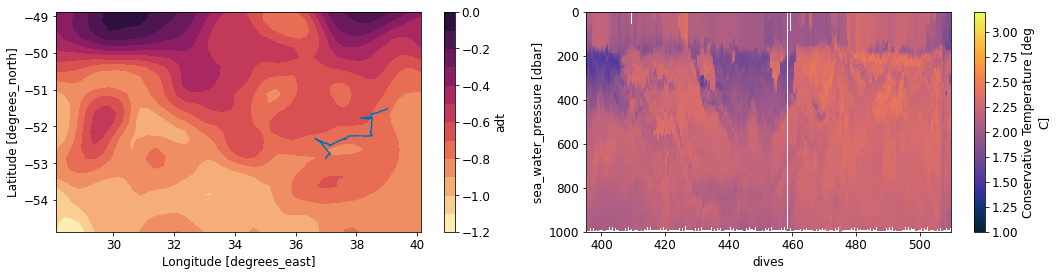

In [79]:
plt.figure(figsize=(15, 4))

ds_660_sel = ds_660_z.where( (ds_660_z.days>=180), drop=True)

plt.subplot(121)
ds_SSH.adt.isel(time=slice(60, 90)).mean('time').plot.contourf(levels=np.linspace(-1.2,0, 13), cmap=cmo.matter)
plt.plot(ds_660_sel.sel(ctd_pressure=200, method='nearest').longitude,
         ds_660_sel.sel(ctd_pressure=200, method='nearest').latitude)

plt.subplot(122)
ds_660_sel.CT.plot(cmap=cmo.thermal, vmin=1, vmax=3.2, rasterized=True)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig('./figures/ssh_sec3.pdf')